# Overview

- 판매량 예측을 위한 다중 변수 데이터 특성 탐색
- Machine Learning 알고리즘 활용 판매량 예측 구현

## Scope
- (In-Scope) EDA & FeatureEngineering, Model Test & Evaludation
- Test Model 
  - Linear Regression
  - Ridge Regression
  - RandomForest Regression
  - Gradient Boosting Regression
  - Support Vector Rgressor
- (Out of Scope) Parameter 최적화, Final Feature/Model 선정

## Library

- setup_requires
  - python==3.7.2 
- install_requires
  - scikit-learn==0.20.31
  - numpy==1.15.4
  - pandas==0.23.4
  - statsmodels==0.9.0

In [1]:
import warnings
import sys
import os
import datetime

import numpy as np
import pandas as pd
import sklearn as sk

import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import probplot


from statsmodels.tsa.stattools import adfuller

import eda
import prep
import model
import util

mpl.rcParams['figure.figsize'] = (8, 5)
mpl.rcParams['axes.grid'] = False

warnings.filterwarnings("ignore")

# Data Collection & Preprocess

## Data Collection
- Data Set: Rossman Sales Data (Kaggle)
- Data Path: ../data/raw/train.csv 

In [2]:
sys_root_path = os.getcwd()
print(f'root_path : {sys_root_path}')

root_path : C:\Users\kkt71\OneDrive\Documents\GitHub\skcc-accuinsight-examples\applying_machine_learning\store_sales_prediction


In [3]:
cur_dir = sys_root_path
data_dir = os.path.join(cur_dir, 'data')
data_raw_dir = os.path.join(data_dir, 'raw')
data_processed_dir = os.path.join(data_dir, 'processed')

## Data File Loading & Preprocess

샘플 데이터 분석을 위한 데이터 확인 및 전처리

In [4]:
file_name = os.path.join(data_raw_dir, 'train.csv')
rossman_df = pd.read_csv(file_name, parse_dates=True, index_col=2)

In [5]:
rossman_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [6]:
rossman_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0


### Change data type
- StateHoliday

In [7]:
rossman_df.dtypes

Store             int64
DayOfWeek         int64
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [8]:
rossman_df['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [9]:
rossman_df['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [10]:
rossman_df['StateHoliday'][rossman_df['StateHoliday']=='0'] = 0
rossman_df['StateHoliday'][rossman_df['StateHoliday']=='a'] = 1
rossman_df['StateHoliday'][rossman_df['StateHoliday']=='b'] = 2
rossman_df['StateHoliday'][rossman_df['StateHoliday']=='c'] = 3

In [11]:
rossman_df['StateHoliday'] = rossman_df['StateHoliday'].astype('int64')

In [12]:
rossman_df.dtypes

Store            int64
DayOfWeek        int64
Sales            int64
Customers        int64
Open             int64
Promo            int64
StateHoliday     int64
SchoolHoliday    int64
dtype: object

### Select Store

In [13]:
print("number of stores:", len(rossman_df["Store"].unique()))

number of stores: 1115


In [14]:
print("start_date: ", rossman_df.index.min())
print("end_date: ", rossman_df.index.max())
print("preiod_in_days: ", pd.Timedelta(rossman_df.index.max() - rossman_df.index.min()).days)

start_date:  2013-01-01 00:00:00
end_date:  2015-07-31 00:00:00
preiod_in_days:  941


In [15]:
print("type of observed periods:", rossman_df["Store"].value_counts().unique())

type of observed periods: [942 941 758]


In [16]:
target_store = pd.DataFrame(rossman_df["Store"].value_counts()).iloc[0,]
print("target store name:", target_store.name)

target store name: 1023


In [17]:
sample_df = rossman_df[(rossman_df["Store"] == target_store.name)]
sample_df = sample_df.drop(columns=["Store"])
sample_df.head()

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-07-31,5,7182,649,1,1,0,1
2015-07-30,4,6348,603,1,1,0,1
2015-07-29,3,6010,544,1,1,0,1
2015-07-28,2,6470,588,1,1,0,1
2015-07-27,1,8230,701,1,1,0,1


### Date Imputation
- 측정 기간 내 누락된 일자 없음

In [18]:
print("start_date: ", sample_df.index.min())
print("end_date: ", sample_df.index.max())
print("count_in_days: ", pd.Timedelta(sample_df.index.max() - sample_df.index.min()).days)

start_date:  2013-01-01 00:00:00
end_date:  2015-07-31 00:00:00
count_in_days:  941


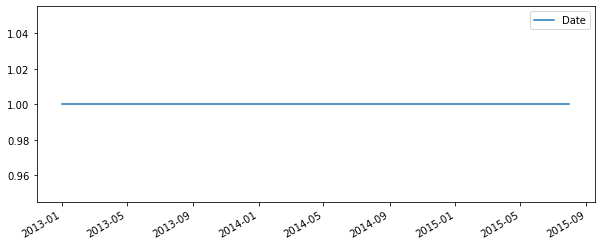

In [19]:
pd.DataFrame(sample_df.index.value_counts()).plot(figsize=(10, 4));

In [20]:
sample_df.index.year.value_counts().sort_index()

2013    365
2014    365
2015    212
Name: Date, dtype: int64

# Feature Engineering

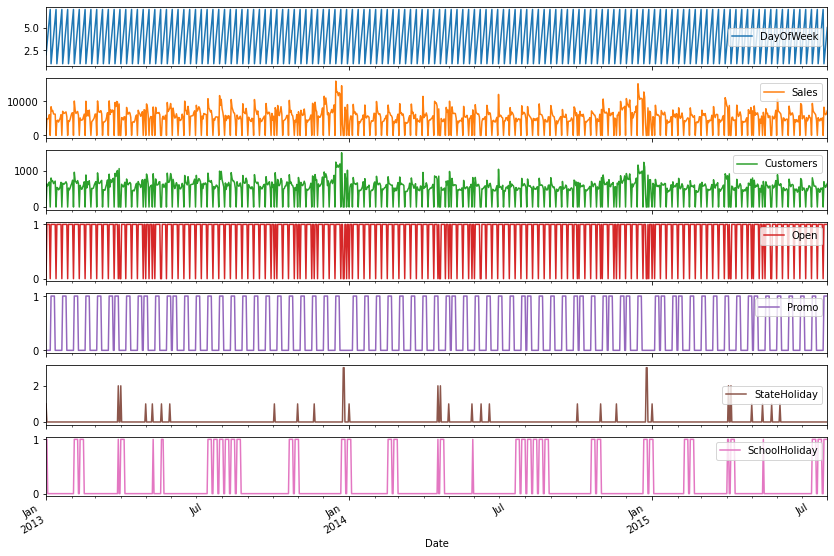

In [21]:
sample_df.plot(subplots=True, figsize=(14, 10));

## Y(Sales)

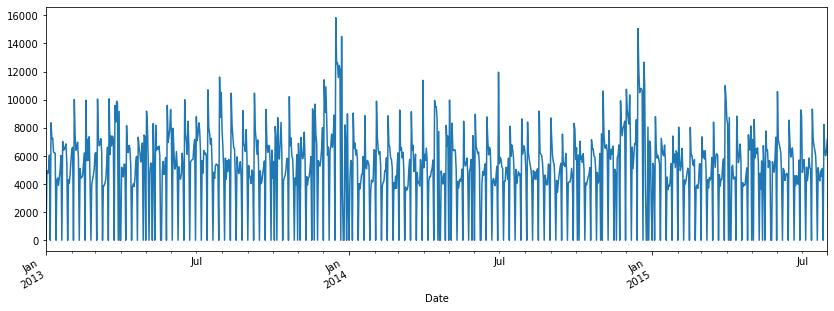

In [22]:
_ = sample_df['Sales'].plot(subplots=True, figsize=(14, 5))

### Histogram

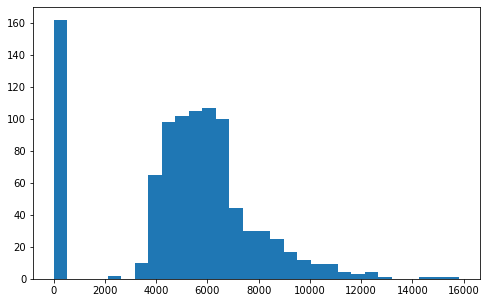

In [23]:
_ = plt.hist(sample_df['Sales'], bins=30)

### Pobability plot

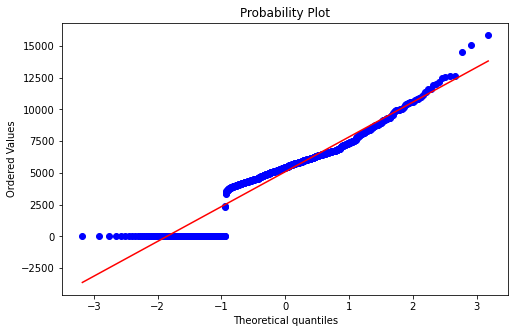

In [24]:
_ = probplot(sample_df['Sales'], dist='norm', plot=plt)

- 변환 불필요. 0을 제외하고는 origianl series가 정규분포와 비슷한 형태를 보임 

### Decomposition

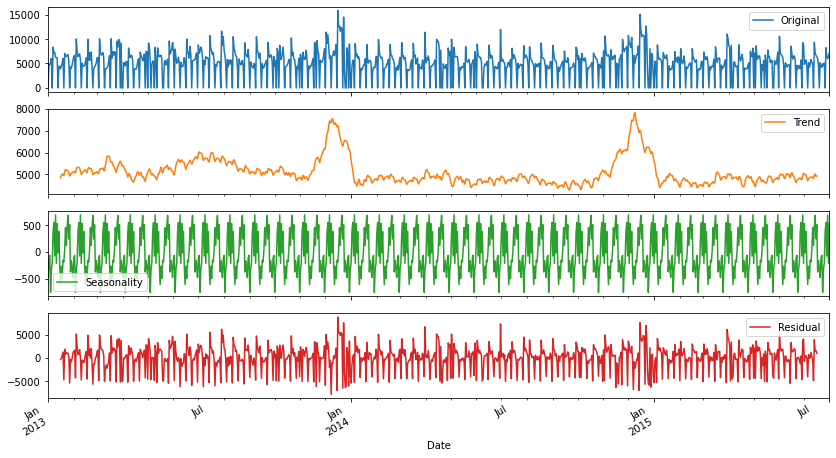

In [25]:
eda.decompose(sample_df, 'Sales', 'additive', 30)

- 전체적인 추세는 없음, 12월(크리스마스 시즌)에 뚜렷한 peak

### ADF Test
- 시계열의 정상성(staionary)를 검정
  - 귀무가설: 단위근을 가진다(비정상성, 안정적이지 않다)
  - 대립가설: 안정적이다.(정상성)
  - 귀무가설을 기각한다(=정상 시계열이 아니라)면, 추가적인 차분을 고려

In [26]:
result = list(adfuller(sample_df['Sales']))
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -4.490259707608817
p-value: 0.00020476419106447397
Critical Values:
	1%: -3.437470108019385
	5%: -2.8646832620852853
	10%: -2.5684436698650503


### Rolling Mean

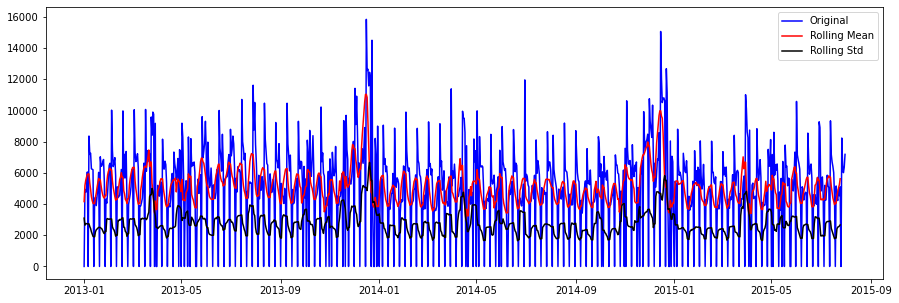

In [27]:
window=7
eda.rolling_mean(sample_df, 'Sales', window)

### Resample

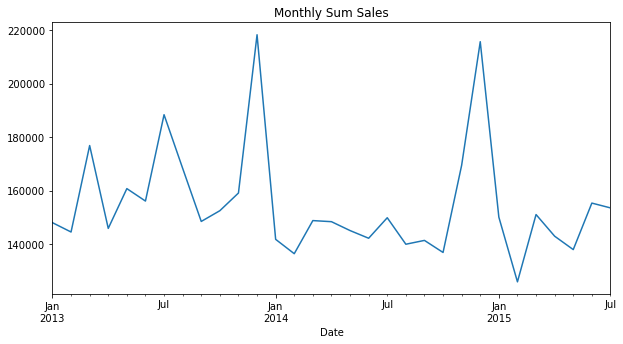

In [28]:
sample_df['Sales'].resample('M').sum().plot.line(title='Monthly Sum Sales', figsize=(10, 5));

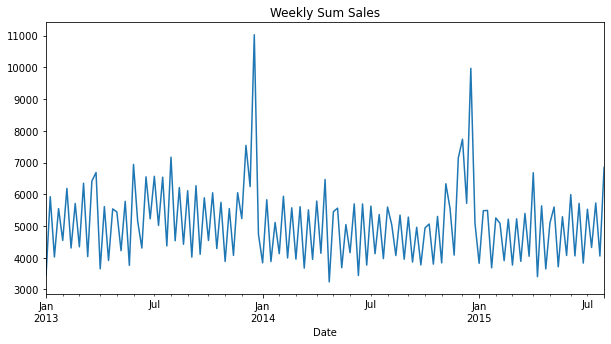

In [29]:
sample_df['Sales'].resample('W').mean().plot.line(title='Weekly Sum Sales', figsize=(10, 5));

## X

In [30]:
sample_df.head()

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-07-31,5,7182,649,1,1,0,1
2015-07-30,4,6348,603,1,1,0,1
2015-07-29,3,6010,544,1,1,0,1
2015-07-28,2,6470,588,1,1,0,1
2015-07-27,1,8230,701,1,1,0,1


### Day of Week

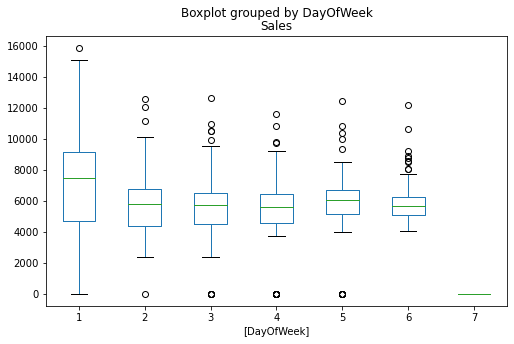

In [31]:
_ = sample_df[['Sales', 'DayOfWeek']].boxplot(by='DayOfWeek', grid=False)

### Open

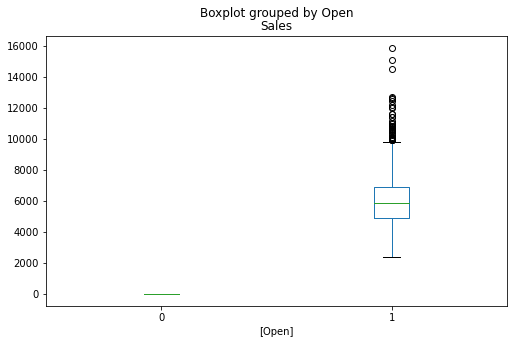

In [32]:
_ = sample_df[['Sales', 'Open']].boxplot(by='Open', grid=False)

### Promo

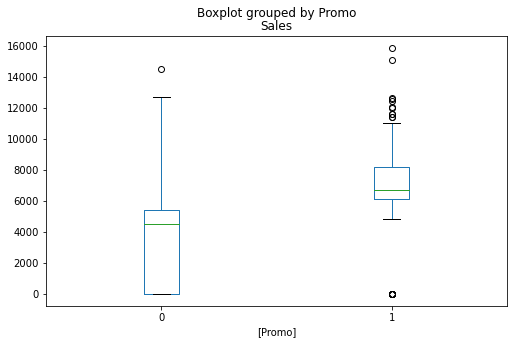

In [33]:
_ = sample_df[['Sales', 'Promo']].boxplot(by='Promo', grid=False)

### StateHoliday

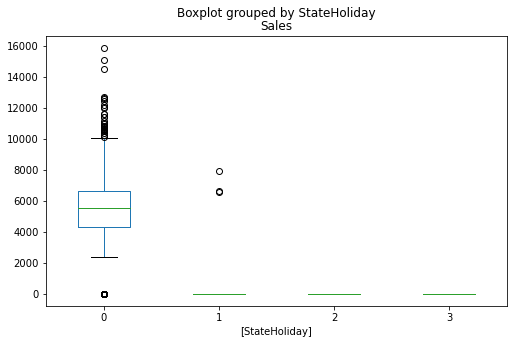

In [34]:
_ = sample_df[['Sales', 'StateHoliday']].boxplot(by='StateHoliday', grid=False)

### SchoolHoliday

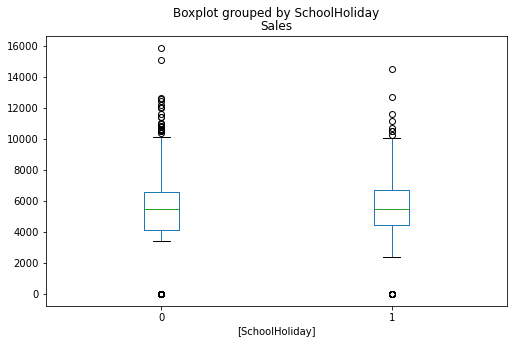

In [35]:
_ = sample_df[['Sales', 'SchoolHoliday']].boxplot(by='SchoolHoliday', grid=False)

### Customers

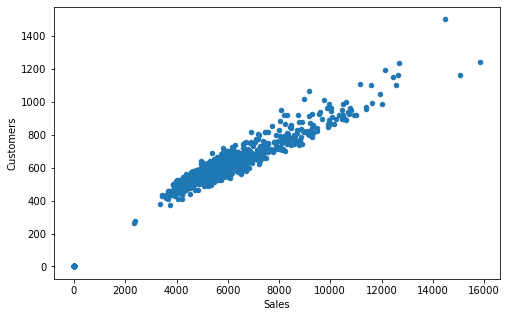

In [36]:
_ = sample_df[['Sales', 'Customers']].plot.scatter(x='Sales', y='Customers')

In [37]:
print("correlation : {:.2f}".format(sample_df['Sales'].corr(sample_df['Customers']) ))

correlation : 0.98


- 상관계수(corr)가 1에 가까울 정도로 높음. Customers 변수는 모델링 대상에서 제외

In [38]:
final_df = sample_df.drop(columns=["Customers"])

### Save Result

In [39]:
file_name = os.path.join(data_processed_dir, 'rossman_sample_final.csv')
final_df.to_csv(file_name, index=True) 

# Modeling & Evaluation

## Load Data

In [40]:
file_name = os.path.join(data_processed_dir, 'rossman_sample_final.csv')
target_df = pd.read_csv(file_name, parse_dates=True, index_col=0)

## Library for ML

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

## Data Prepare
ML Modeling 위한 데이터 준비 
- pd.DataFrame -> np.array로 변환
- one-hot encoding
- Polynomial(degree=2), Interaction 변수 추가
- Sales Lag1~5 feature 추가 

In [42]:
target_df.dtypes

DayOfWeek        int64
Sales            int64
Open             int64
Promo            int64
StateHoliday     int64
SchoolHoliday    int64
dtype: object

In [43]:
y = target_df['Sales'].values.reshape(-1,1)
X = np.hstack([target_df['DayOfWeek'].values.reshape(-1,1),
               target_df['Open'].values.reshape(-1,1), 
               target_df['Promo'].values.reshape(-1,1), 
               target_df['StateHoliday'].values.reshape(-1,1), 
               target_df['SchoolHoliday'].values.reshape(-1,1)])

In [44]:
X_onehot, X_names_onehot = prep.onehot(X, ['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday'])

(942, 17)


In [45]:
X_onehot_poly, X_names_onehot_poly = prep.poly_transform(X_onehot, X_names_onehot, 2)

(942, 153)
['DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'Open_0', 'Open_1', 'Promo_0', 'Promo_1', 'StateHoliday_0', 'StateHoliday_1', 'StateHoliday_2', 'StateHoliday_3', 'SchoolHoliday_0', 'SchoolHoliday_1', 'DayOfWeek_1 DayOfWeek_2', 'DayOfWeek_1 DayOfWeek_3', 'DayOfWeek_1 DayOfWeek_4', 'DayOfWeek_1 DayOfWeek_5', 'DayOfWeek_1 DayOfWeek_6', 'DayOfWeek_1 DayOfWeek_7', 'DayOfWeek_1 Open_0', 'DayOfWeek_1 Open_1', 'DayOfWeek_1 Promo_0', 'DayOfWeek_1 Promo_1', 'DayOfWeek_1 StateHoliday_0', 'DayOfWeek_1 StateHoliday_1', 'DayOfWeek_1 StateHoliday_2', 'DayOfWeek_1 StateHoliday_3', 'DayOfWeek_1 SchoolHoliday_0', 'DayOfWeek_1 SchoolHoliday_1', 'DayOfWeek_2 DayOfWeek_3', 'DayOfWeek_2 DayOfWeek_4', 'DayOfWeek_2 DayOfWeek_5', 'DayOfWeek_2 DayOfWeek_6', 'DayOfWeek_2 DayOfWeek_7', 'DayOfWeek_2 Open_0', 'DayOfWeek_2 Open_1', 'DayOfWeek_2 Promo_0', 'DayOfWeek_2 Promo_1', 'DayOfWeek_2 StateHoliday_0', 'DayOfWeek_2 StateHoliday_1', 'DayOfWeek_2

lag1~5를 Feature에 추가하고 Test

In [46]:
X_onehot_poly_lag5, X_names_onehot_poly_lag5 = prep.add_lag(target_df, X_onehot_poly, X_names_onehot_poly)

(942, 158)
['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5']


In [47]:
n_train = np.round(len(target_df) * 0.7).astype('int')

# start_date:  2013-01-01 00:00:00
# end_date:  2015-07-31 00:00:00
date_ticks = pd.date_range(start="2013-01-01", end="2015-07-31", freq='D')

## Linear Regression
- Input feature를 X, X_onehot, X_onehot_poly, X_onehot_poly_lag5로 변경해보면서 성능 확인

Train MAE: 992.77
Test MAE: 758.71


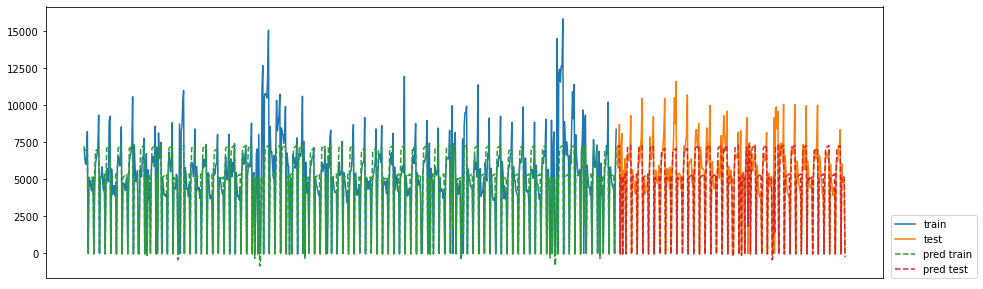

In [48]:
model.eval_on_features(n_train, date_ticks, X, y, LinearRegression())

Train MAE: 868.30
Test MAE: 666.59


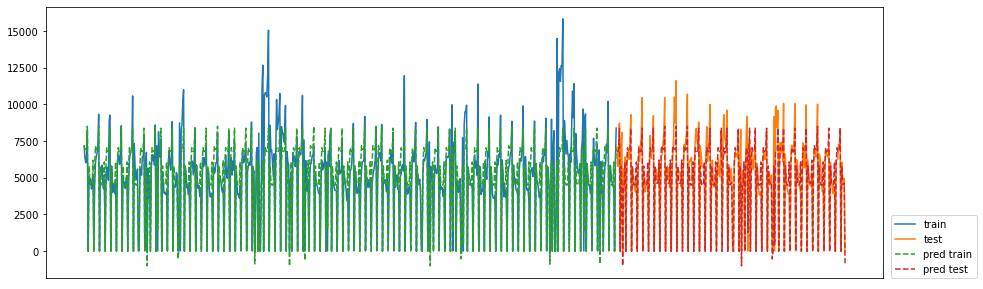

In [49]:
model.eval_on_features(n_train, date_ticks, X_onehot, y, LinearRegression())

Train MAE: 805.41
Test MAE: 67118479086555.97


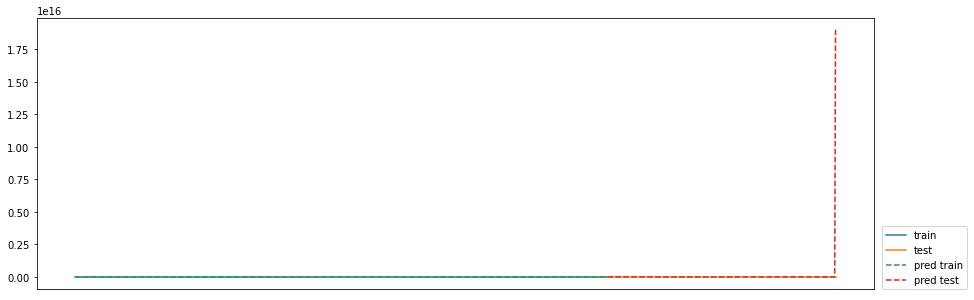

In [50]:
model.eval_on_features(n_train, date_ticks, X_onehot_poly, y, LinearRegression())

Train MAE: 768.54
Test MAE: 669.84


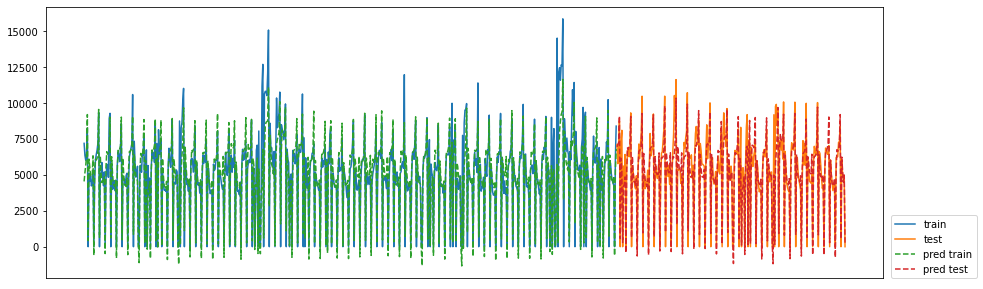

In [51]:
model.eval_on_features(n_train, date_ticks, X_onehot_poly_lag5, y, LinearRegression())

## Ridge Regression

Train MAE: 863.15
Test MAE: 668.17


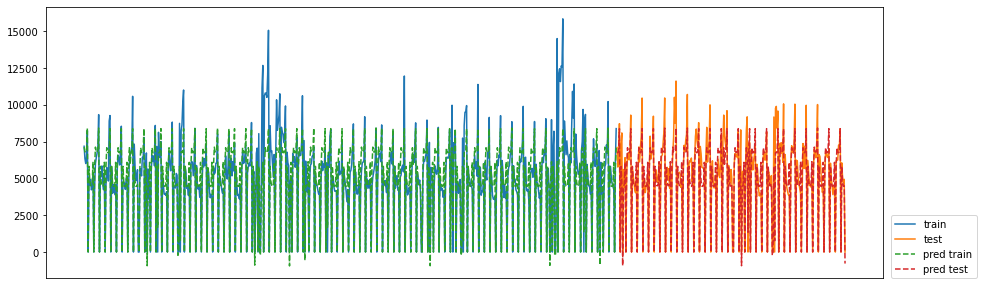

In [52]:
rlr = Ridge()
model.eval_on_features(n_train, date_ticks, X_onehot, y, rlr)

Train MAE: 772.76
Test MAE: 608.04


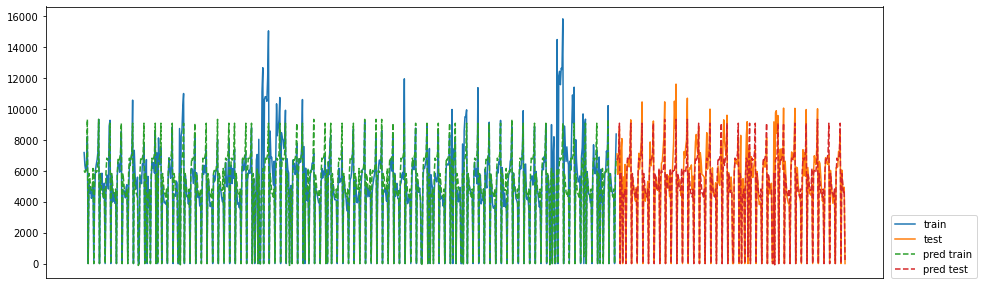

In [53]:
model.eval_on_features(n_train, date_ticks, X_onehot_poly, y, rlr)

Train MAE: 769.17
Test MAE: 670.11


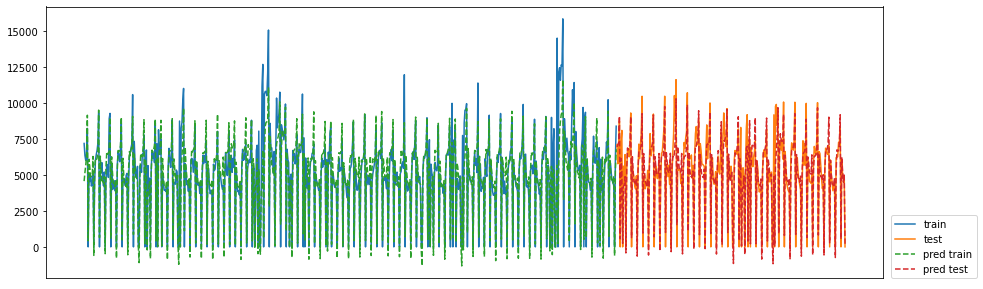

In [54]:
rlr = model.eval_on_features_returnmodel(n_train, date_ticks, X_onehot_poly_lag5, y, rlr)

### Coefficient Check
- Train/Test 성능이 가장 좋은 마지막 모델(ridge, input = X_onehot_poly_lag5)의 변수별 coef 확인

                     X_name   ridge_coef
13                   Open_1  1014.546842
123          Open_1 Promo_1   900.434502
31      DayOfWeek_1 Promo_1   673.466861
128  Open_1 SchoolHoliday_0   621.729847
125   Open_1 StateHoliday_1   564.978964


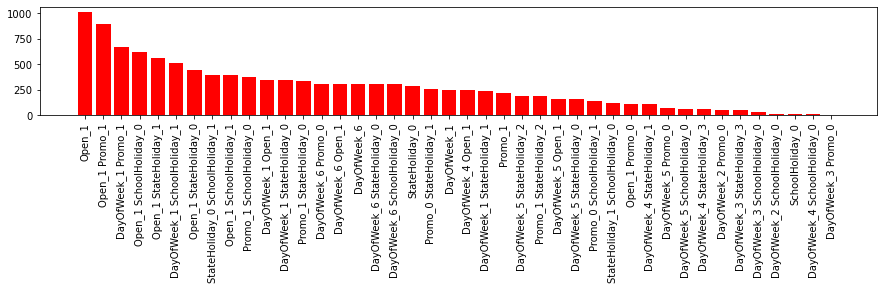

In [55]:
threshold = 0.5
model.check_coefficient(rlr, X_names_onehot_poly_lag5, threshold)

- coef가 0.5보다 큰 것만 plotting

## RandomForest

Train MAE: 759.17
Test MAE: 614.17


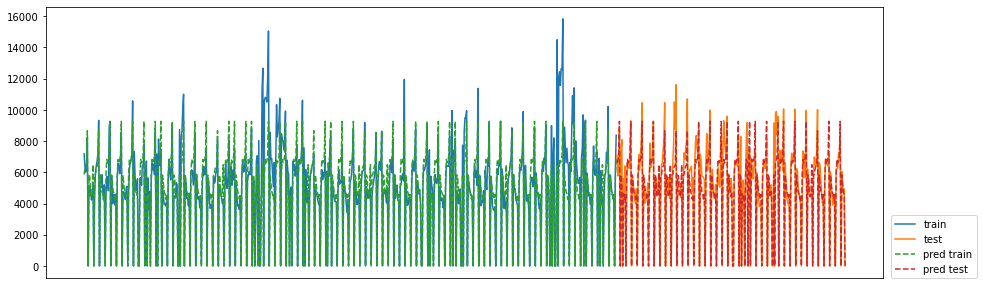

In [57]:
rfr = RandomForestRegressor(n_estimators=100, random_state=0)
model.eval_on_features(n_train, date_ticks, X_onehot, y, rfr)

Train MAE: 760.01
Test MAE: 615.22


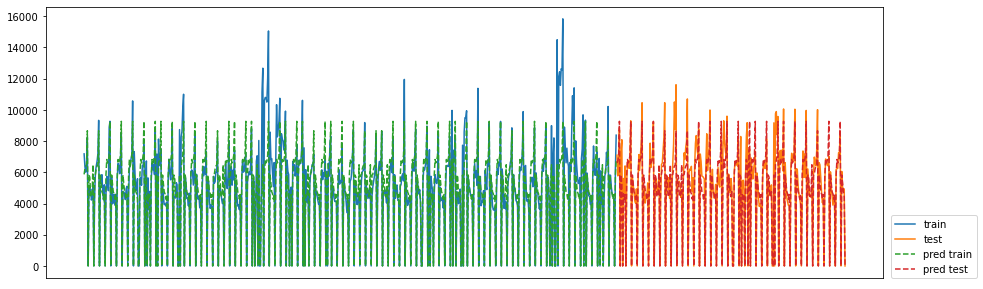

In [59]:
model.eval_on_features(n_train, date_ticks, X_onehot_poly, y, rfr)

Train MAE: 205.96
Test MAE: 566.33


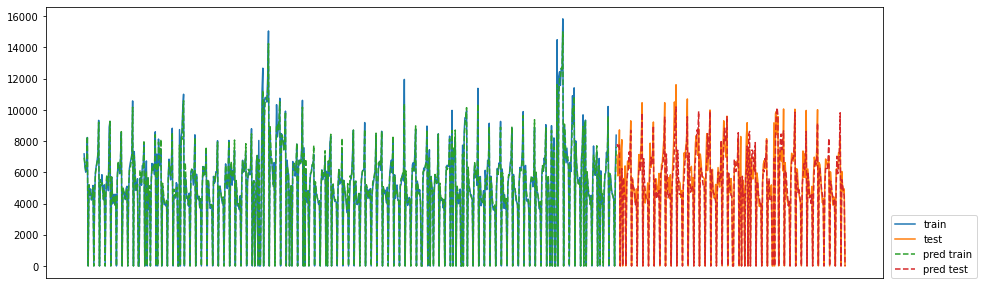

In [61]:
rfr = model.eval_on_features_returnmodel(n_train, date_ticks, X_onehot_poly_lag5, y, rfr)

### Variable Importance
- 가장 성능이 좋은 마지막 rfr모델(input = X_onehot_poly_lag5)의 변수 중요도 확인

In [60]:
rfr_importance = rfr.feature_importances_

In [61]:
importance_df = pd.DataFrame(list(zip(X_names_onehot_poly_lag5, rfr_importance)), columns=['X_name', 'importances'])
threshhold = 0.005
high_importances = importance_df[importance_df['importances']>threshhold]
high_importances = high_importances.sort_values(by=['importances'], ascending=False)
print(high_importances)

                         X_name  importances
13                       Open_1     0.373179
12                       Open_0     0.235201
0                          lag1     0.162677
1                          lag2     0.042612
124       Open_1 StateHoliday_0     0.031261
31          DayOfWeek_1 Promo_1     0.028370
2                          lag3     0.021165
122              Open_1 Promo_0     0.013648
3                          lag4     0.013223
131      Promo_0 StateHoliday_0     0.011749
14                      Promo_0     0.010178
4                          lag5     0.010113
123              Open_1 Promo_1     0.008164
15                      Promo_1     0.005745
32   DayOfWeek_1 StateHoliday_0     0.005404
29           DayOfWeek_1 Open_1     0.005310


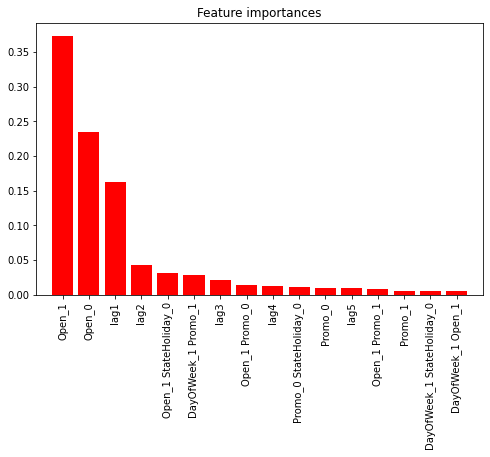

In [62]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(high_importances.shape[0]), high_importances['importances'], color="r", align="center")
plt.xticks(range(high_importances.shape[0]), high_importances['X_name'], rotation=90)
plt.xlim([-1, high_importances.shape[0]])
plt.show()

## Gradient Boosting Regressor

Train MAE: 766.73
Test MAE: 607.73


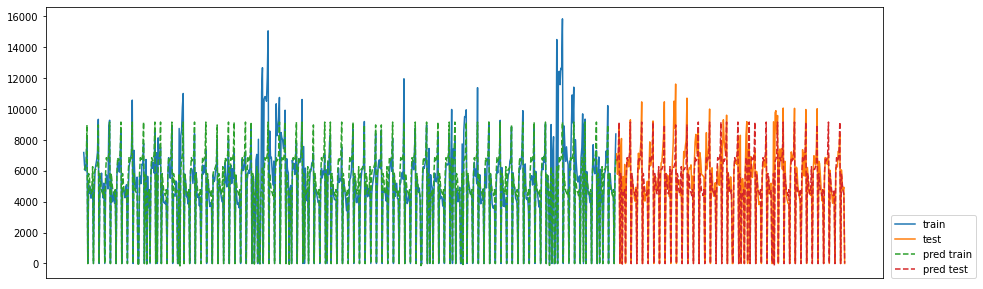

In [63]:
# key param: n_estimators, learning_rate, max_depth
gbr = GradientBoostingRegressor(random_state=0) 
eval_on_features(X_onehot, y, gbr)

Train MAE: 761.46
Test MAE: 616.50


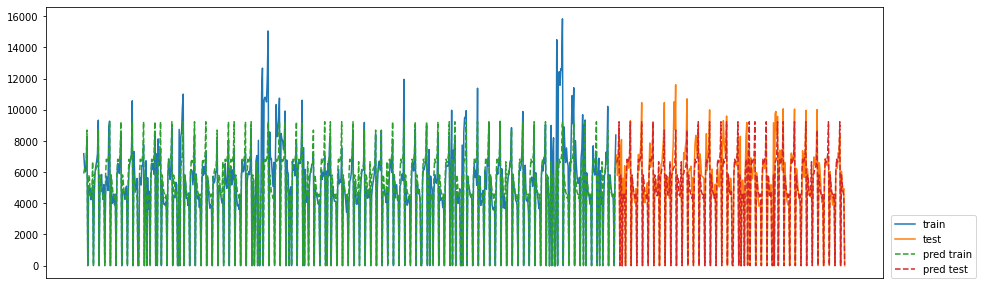

In [64]:
eval_on_features(X_onehot_poly, y, gbr)

Train MAE: 382.20
Test MAE: 581.13


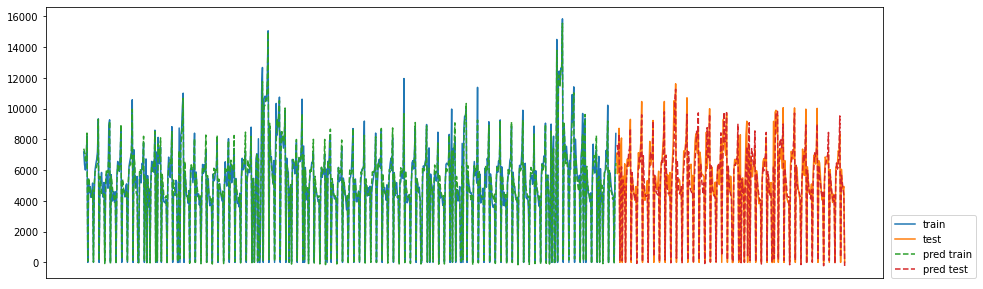

In [65]:
eval_on_features(X_onehot_poly_lag5, y, gbr)

## Support Vector Regressor

Train MAE: 1780.17
Test MAE: 1743.13


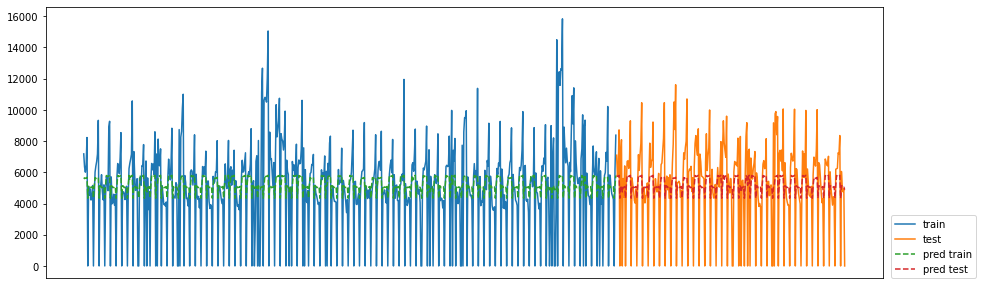

In [66]:
# key param: n_estimators, learning_rate, max_depth
svr = SVR(kernel="poly", gamma='auto', degree=2, C=100, epsilon=0.1)
eval_on_features(X_onehot, y, svr)

Train MAE: 2054.53
Test MAE: 2013.08


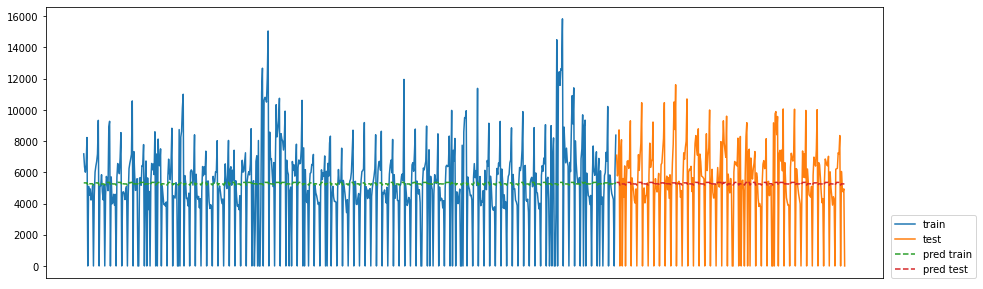

In [67]:
eval_on_features(X_onehot_poly, y, svr)

In [68]:
# eval_on_features(X_onehot_poly_lag5, y, svr)

 - fail to converge

## ML Model Result
- Random Forest Regressor와 Gradient Boosting Regressor가 가장 좋은 성능을 보임
- Random Forest Best (Feature: X_onehot_poly_lag5)
  - Train MAE: 205.96
  - Test MAE: 566.33
- Gradient Boosting Regressor Best (Feature: X_onehot_poly_lag5)
  - Train MAE: 382.20
  - Test MAE: 580.13

# To-Dos
- 추가 Feature Enginerring(Dimension Reduction 등), Final Feature & Model 선정, Parameter 최적화